<a href="https://colab.research.google.com/github/Ashishkr108/Learning-Path/blob/main/face_recognition_dlib_raw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

http://dlib.net/files/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import sys
import dlib
import numpy as np
from skimage import io
import cv2

In [ ]:
from zipfile import ZipFile

In [ ]:
zpath = 'drive/MyDrive//zummit/dlib-18.16.zip'
from zipfile import ZipFile
# opening the zip file in READ mode
with ZipFile(zpath, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

In [ ]:
# clone repo
!git clone https://github.com/nicolasmetallo/eameo-faceswap-generator

Cloning into 'eameo-faceswap-generator'...
remote: Enumerating objects: 266, done.
remote: Counting objects: 100% (16/16), done.
remote: Total 266 (delta 15), reused 15 (delta 15), pack-reused 250
Receiving objects: 100% (266/266), 168.59 MiB | 29.13 MiB/s, done.
Resolving deltas: 100% (88/88), done.


In [ ]:
path = 'eameo-faceswap-generator'
predictor_path = path + '/shape_predictor_68_face_landmarks.dat'

In [ ]:
data_dir = 'dlib-18.16'
face_rec_model_path = 'drive/MyDrive/zummit/dlib_face_recognition_resnet_model_v1.dat'
faces_folder_path = 'drive/MyDrive/zummit/'

In [ ]:
# Load all the models we need: a detector to find the faces,
# a shape predictor to find face landmarks so we can precisely localize the face,
# and finally the face recognition model.
face_detector = dlib.get_frontal_face_detector()
shape_predictor = dlib.shape_predictor(predictor_path)
face_recognition_model = dlib.face_recognition_model_v1(face_rec_model_path)

In [ ]:
win = dlib.image_window()

In [ ]:
# This is the tolerance for face comparisons
# The lower the number - the stricter the comparison
# To avoid false matches, use lower value
# To avoid false negatives (i.e. faces of the same person doesn't match), use higher value
# 0.5-0.6 works well
TOLERANCE = 0.6

In [ ]:
# This function will take an image and return its face encodings using the neural network
def get_face_encodings(image):
    # Detect faces using the face detector
    detected_faces = face_detector(image, 1)
    # Get pose/landmarks of those faces
    # Will be used as an input to the function that computes face encodings
    # This allows the neural network to be able to produce similar numbers for faces of the same people, regardless of camera angle and/or face positioning in the image
    shapes_faces = [shape_predictor(image, face) for face in detected_faces]
    # For every face detected, compute the face encodings
    return [np.array(face_recognition_model.compute_face_descriptor(image, face_pose, 1)) for face_pose in shapes_faces]

In [ ]:
d = face_detector(image, 1)

In [ ]:
# This function takes a list of known faces
def compare_face_encodings(known_faces, face):
    # Finds the difference between each known face and the given face (that we are comparing)
    # Calculate norm for the differences with each known face
    # Return an array with True/Face values based on whether or not a known face matched with the given face
    # A match occurs when the (norm) difference between a known face and the given face is less than or equal to the TOLERANCE value
    return (np.linalg.norm(known_faces - face, axis=1) <= TOLERANCE)

In [ ]:
# This function returns the name of the person whose image matches with the given face (or 'Not Found')
# known_faces is a list of face encodings
# names is a list of the names of people (in the same order as the face encodings - to match the name with an encoding)
# face is the face we are looking for
def find_match(known_faces, names, face):
    # Call compare_face_encodings to get a list of True/False values indicating whether or not there's a match
    matches = compare_face_encodings(known_faces, face)
    # Return the name of the first match
    count = 0
    for match in matches:
        if match:
            return names[count]
        count += 1
    # Return not found if no match found
    return 'Not Found'

In [ ]:
a = os.listdir(faces_folder_path)
c=[]
for i  in a :
  if i.endswith('.jpg') == True:
    c.append(i)
print(c)

['superman.jpg', 'henrycavill.jpg']


In [ ]:
# Get path to all the known images
# Filtering on .jpg extension - so this will only work with JPEG images ending with .jpg
image_filenames = filter(lambda x: x.endswith('.jpg'), os.listdir(faces_folder_path))
# Sort in alphabetical order
image_filenames = sorted(image_filenames)
# Get full paths to images
paths_to_images = [faces_folder_path + x for x in image_filenames]
# List of face encodings we have
face_encodings = []
# Loop over images to get the encoding one by one
for path_to_image in paths_to_images:
    # Load image using scipy
    image = io.imread(path_to_image)
    # Get face encodings from the image
    face_encodings_in_image = get_face_encodings(image)
    # Make sure there's exactly one face in the image
    if len(face_encodings_in_image) != 1:
        print("Please change image: " + path_to_image + " - it has " + str(len(face_encodings_in_image)) + " faces; it can only have one")
        exit()
    # Append the face encoding found in that image to the list of face encodings we have
    face_encodings.append(face_encodings_in_image[0])

In [ ]:
names = [x[:-4] for x in image_filenames]

In [ ]:
faceClassifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
cap = cv2.VideoCapture(0)   # cv2.VideoCapture("./out.mp4")

In [ ]:
while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faceRects = faceClassifier.detectMultiScale(
        gray,
        scaleFactor = 1.1,
        minNeighbors = 5,
        minSize = (50, 50),
        flags = cv2.CASCADE_SCALE_IMAGE)

    for (x, y, w, h) in faceRects:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        face = frame[y:y + h, x:x + w]
        face_encodings_in_image = get_face_encodings(face)
        if (face_encodings_in_image):
            match = find_match(face_encodings, names, face_encodings_in_image[0])
            cv2.putText(frame, match, (x+10, y+30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

    cv2.imshow("bilde", frame)

    if cv2.waitKey(10) == 27:
        break

In [ ]:
cap.release()
cv2.destroyAllWindows()

Face replacement with python,dlib and open cv
https://colab.research.google.com/github/nicolasmetallo/eameo-faceswap-generator/blob/master/face-swap-step-by-step.ipynb#scrollTo=BC6BuD6jrEgb

In [ ]:
# clone repo
!git clone https://github.com/nicolasmetallo/eameo-faceswap-generator

Cloning into 'eameo-faceswap-generator'...
remote: Enumerating objects: 266, done.
remote: Counting objects: 100% (16/16), done.
remote: Total 266 (delta 15), reused 15 (delta 15), pack-reused 250
Receiving objects: 100% (266/266), 168.59 MiB | 30.03 MiB/s, done.
Resolving deltas: 100% (88/88), done.


In [ ]:
# cd into directory
cd eameo-faceswap-generator

In [ ]:
# Import modules
import sys, cv2, dlib, time
import numpy as np
import faceBlendCommon as fbc
import matplotlib.pyplot as plt

In [ ]:
# Read images
#img1 = read_url_or_local_image(from_image)
#img2 = read_url_or_local_image(to_image)
img1 = cv2.imread('image.jpg')
img2 = cv2.imread('images.jfif')

im1Display = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
im2Display = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

img1Warped = np.copy(img2)

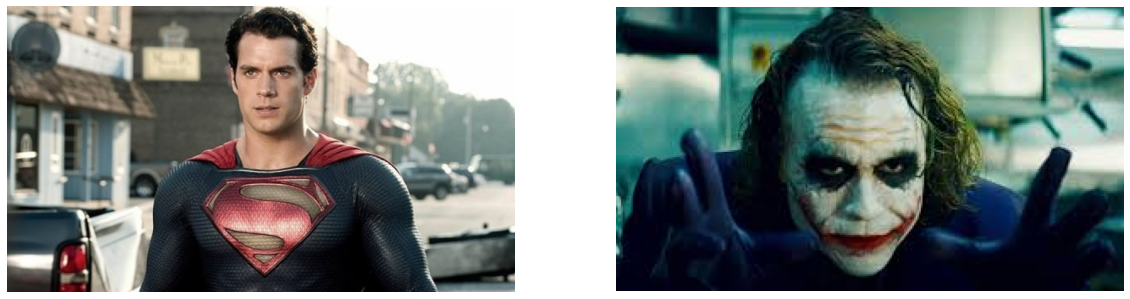

In [ ]:
# Display Images 
plt.figure(figsize = (20,10))
plt.subplot(121); plt.imshow(im1Display); plt.axis('off');
plt.subplot(122); plt.imshow(im2Display); plt.axis('off');

In [ ]:
# Initialize the dlib facial landmakr detector
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("eameo-faceswap-generator/shape_predictor_68_face_landmarks.dat")
# Read array of corresponding points
points1 = fbc.getLandmarks(detector, predictor, img1)
points2 = fbc.getLandmarks(detector, predictor, img2)

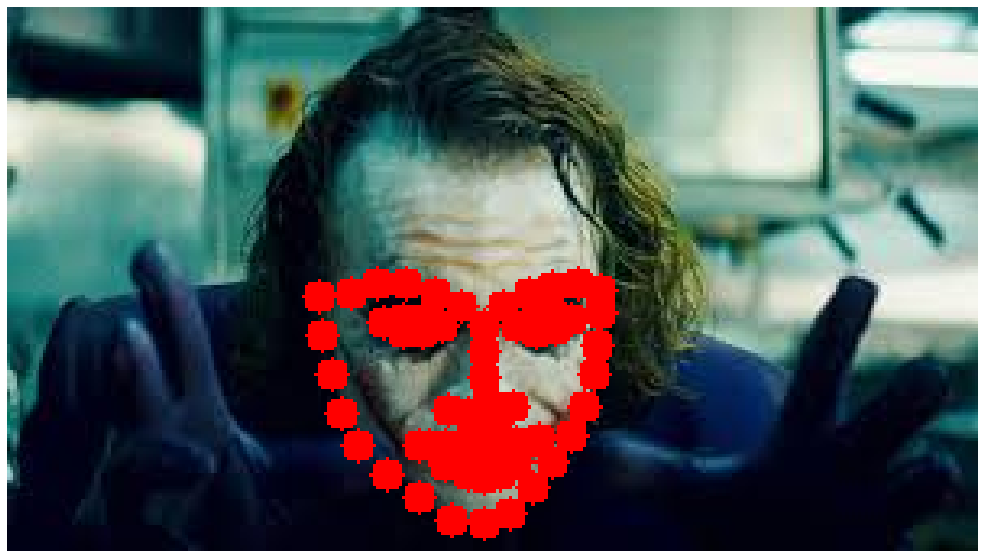

In [ ]:
imTemp = im2Display.copy()
for p in points2:
    cv2.circle(imTemp, p, 5, (255,0,0), -1)

plt.figure(figsize = (20,10)); plt.imshow(imTemp); plt.axis('off');

In [ ]:
# Find convex hull
hullIndex = cv2.convexHull(np.array(points2).astype(np.int32), returnPoints=False) # add .astype(np.int32) to fix TypeError: data type = 9 not supported

# Create convex hull lists
hull1 = []
hull2 = []
for i in range(0, len(hullIndex)):
    hull1.append(points1[hullIndex[i][0]])
    hull2.append(points2[hullIndex[i][0]])

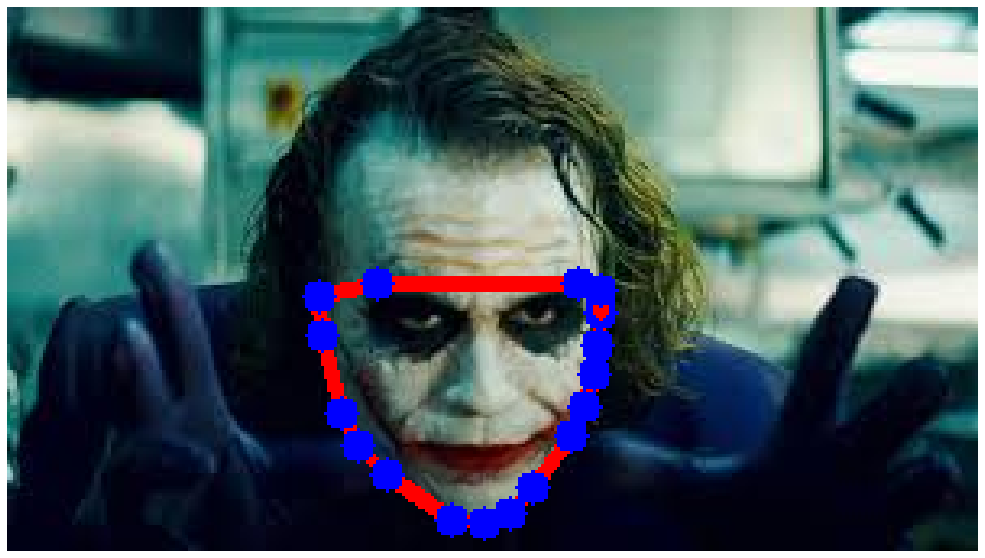

In [ ]:
imTemp = im2Display.copy()
numPoints = len(hull2)
for i in range(0, numPoints):
    cv2.line(imTemp, hull2[i], hull2[(i+1)%numPoints], (255,0,0), 3)
    cv2.circle(imTemp, hull2[i], 5, (0,0,255), -1)
plt.figure(figsize = (20,10)); plt.imshow(imTemp); plt.axis('off');

In [ ]:
# Calculate Mask for Seamless cloning
hull8U = []
for i in range(0, len(hull2)):
    hull8U.append((hull2[i][0], hull2[i][1]))

mask = np.zeros(img2.shape, dtype=img2.dtype) 
cv2.fillConvexPoly(mask, np.int32(hull8U), (255, 255, 255))

# Find Centroid
m = cv2.moments(mask[:,:,1])
center = (int(m['m10']/m['m00']), int(m['m01']/m['m00']))

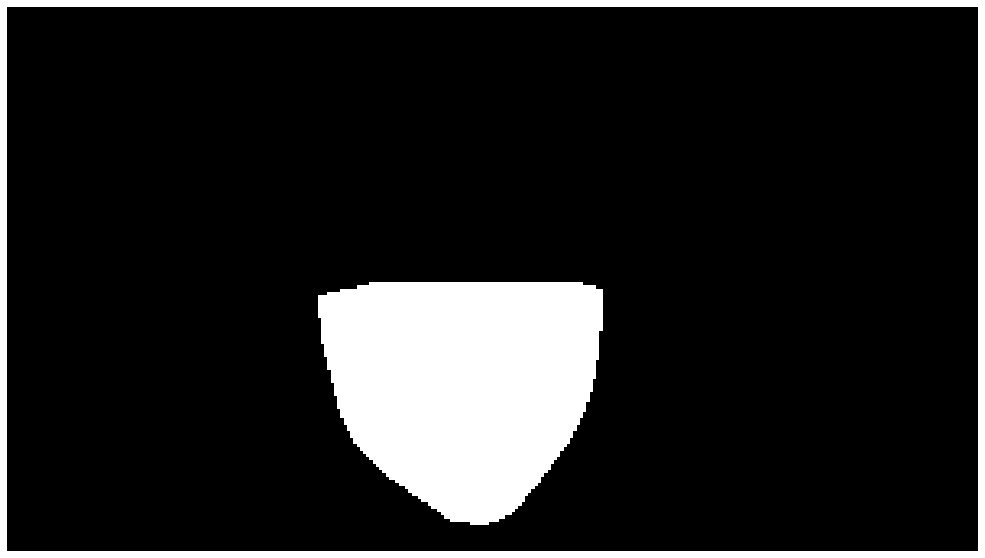

In [ ]:
plt.figure(figsize = (20,10)); plt.imshow(mask); plt.axis('off');

In [ ]:
# Find Delaunay traingulation for convex hull points
sizeImg2 = img2.shape    
rect = (0, 0, sizeImg2[1], sizeImg2[0])

dt = fbc.calculateDelaunayTriangles(rect, hull2)

# If no Delaunay Triangles were found, quit
if len(dt) == 0:
    quit()

In [ ]:
imTemp1 = im1Display.copy()
imTemp2 = im2Display.copy()

tris1 = []
tris2 = []
for i in range(0, len(dt)):
    tri1 = []
    tri2 = []
    for j in range(0, 3):
        tri1.append(hull1[dt[i][j]])
        tri2.append(hull2[dt[i][j]])

    tris1.append(tri1)
    tris2.append(tri2)

cv2.polylines(imTemp1,np.array(tris1).astype(np.int32),True,(0,0,255),2);
cv2.polylines(imTemp2,np.array(tris2).astype(np.int32),True,(0,0,255),2);

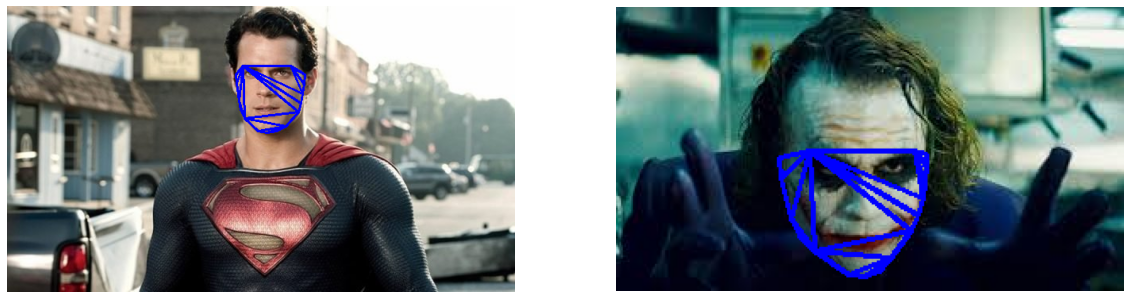

In [ ]:
plt.figure(figsize = (20,10)); 
plt.subplot(121); plt.imshow(imTemp1); plt.axis('off');
plt.subplot(122); plt.imshow(imTemp2); plt.axis('off');

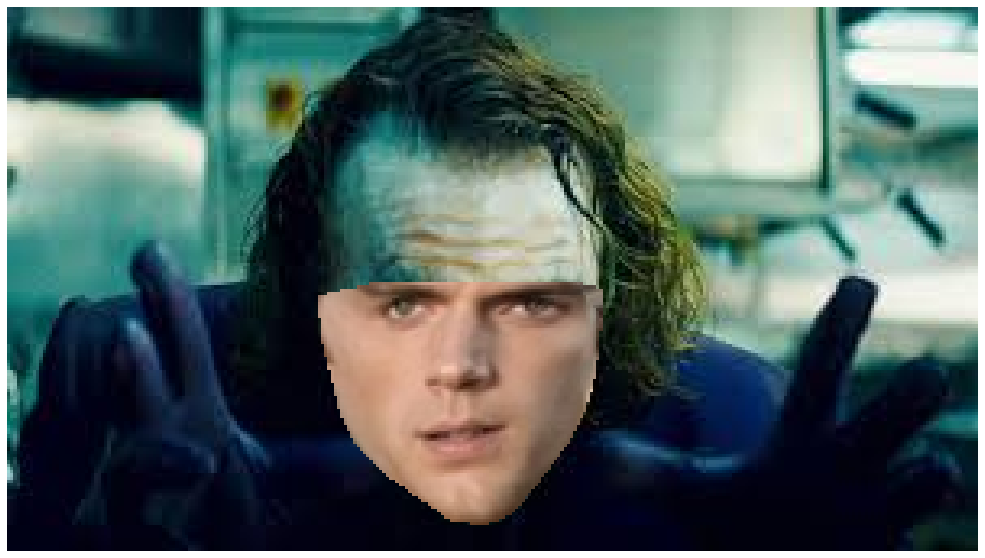

In [ ]:
# Apply affine transformation to Delaunay triangles
for i in range(0, len(tris1)):
    fbc.warpTriangle(img1, img1Warped, tris1[i], tris2[i])

plt.figure(figsize=(20,10));
plt.imshow(np.uint8(img1Warped)[:,:,::-1]); plt.axis('off');

In [ ]:
# Clone seamlessly.
output = cv2.seamlessClone(np.uint8(img1Warped), img2, mask, center, cv2.NORMAL_CLONE)

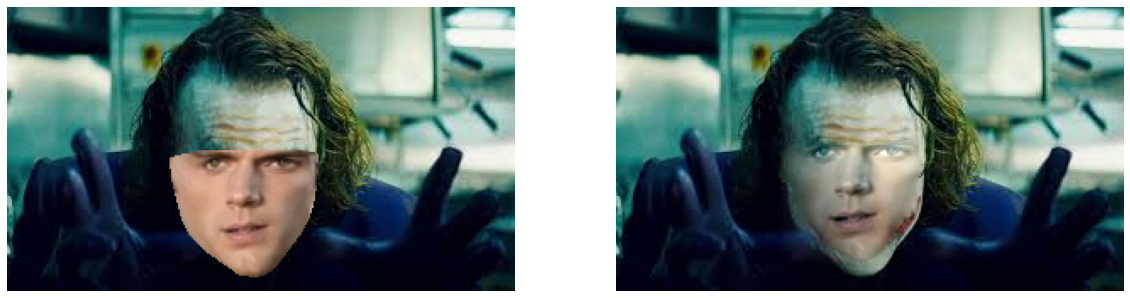

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot((121)); plt.imshow(np.uint8(img1Warped)[:,:,::-1]); plt.axis('off');
plt.subplot((122)); plt.imshow(output[:,:,::-1]); plt.axis('off');